# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:.0f}'.format

Please check the data_for_feature_analysis folder to get this data

In [ ]:
df = pd.read_csv('data_professors.csv')
df_q = pd.read_csv('question_matrices.csv')
df_res = pd.read_csv('results_random_forest.csv')
df_excel = pd.read_excel('dev.xlsx')

In [ ]:
df_q.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
df = df.fillna(0)

In [ ]:
len(['question'] + df.columns[1:])

92

In [ ]:
df_q.columns = ['question'] + df.columns[1:].tolist()

In [ ]:
df_q.head(2)

,question,high_frequency_trading_bool,quantitative_finance,computational_finance_bool,drug_discovery_bool,cancer_bool,biology_bool,radiology_bool,neuroscience_bool,evolution_bool,...,physics_bool,cyber_physical_systems,physical_substrates,game_theory_bool,antitrust_bool,runtime,chatbot,law_bool,networking_bool,cloud_computing_bool
0,What is my favorite ice cream?,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,I want to do a capstone on the historical infl...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_res.head(2)

,Unnamed: 0,chatbot_answer
0,0,Ryan Baker
1,1,Ryan Baker


In [ ]:
df_excel.head(2)

,Test/Dev Input,Expected Response,Name (if applicable)
0,What is my favorite ice cream?,I do not know the answer to that,NaN
1,I want to do a capstone on the historical infl...,I am only able to recommend professors that wo...,NaN


In [ ]:
df.head(2)

,professor,high_frequency_trading_bool,quantitative_finance,computational_finance_bool,drug_discovery_bool,cancer_bool,biology_bool,radiology_bool,neuroscience_bool,evolution_bool,...,physics_bool,cyber_physical_systems,physical_substrates,game_theory_bool,antitrust_bool,runtime,chatbot,law_bool,networking_bool,cloud_computing_bool
0,Bong Ho Kim,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Junhyong Kim,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X = df.drop(columns='professor')
y = df[['professor']]

## Feature Importance Approach - Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=0)
forest.fit(X, y)

<ipython-input-88-9376c43c803e>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X, y)


RandomForestClassifier(random_state=0)

In [ ]:
%%time
importances = forest.feature_importances_

CPU times: user 6.63 ms, sys: 3.08 ms, total: 9.71 ms
Wall time: 9.07 ms


In [ ]:
importance_series = pd.Series(importances)
feature_name_series = pd.Series(df.drop(columns='professor').columns)
frame = {'feature': feature_name_series, 'importance': importance_series}
forest_df = pd.DataFrame(frame)

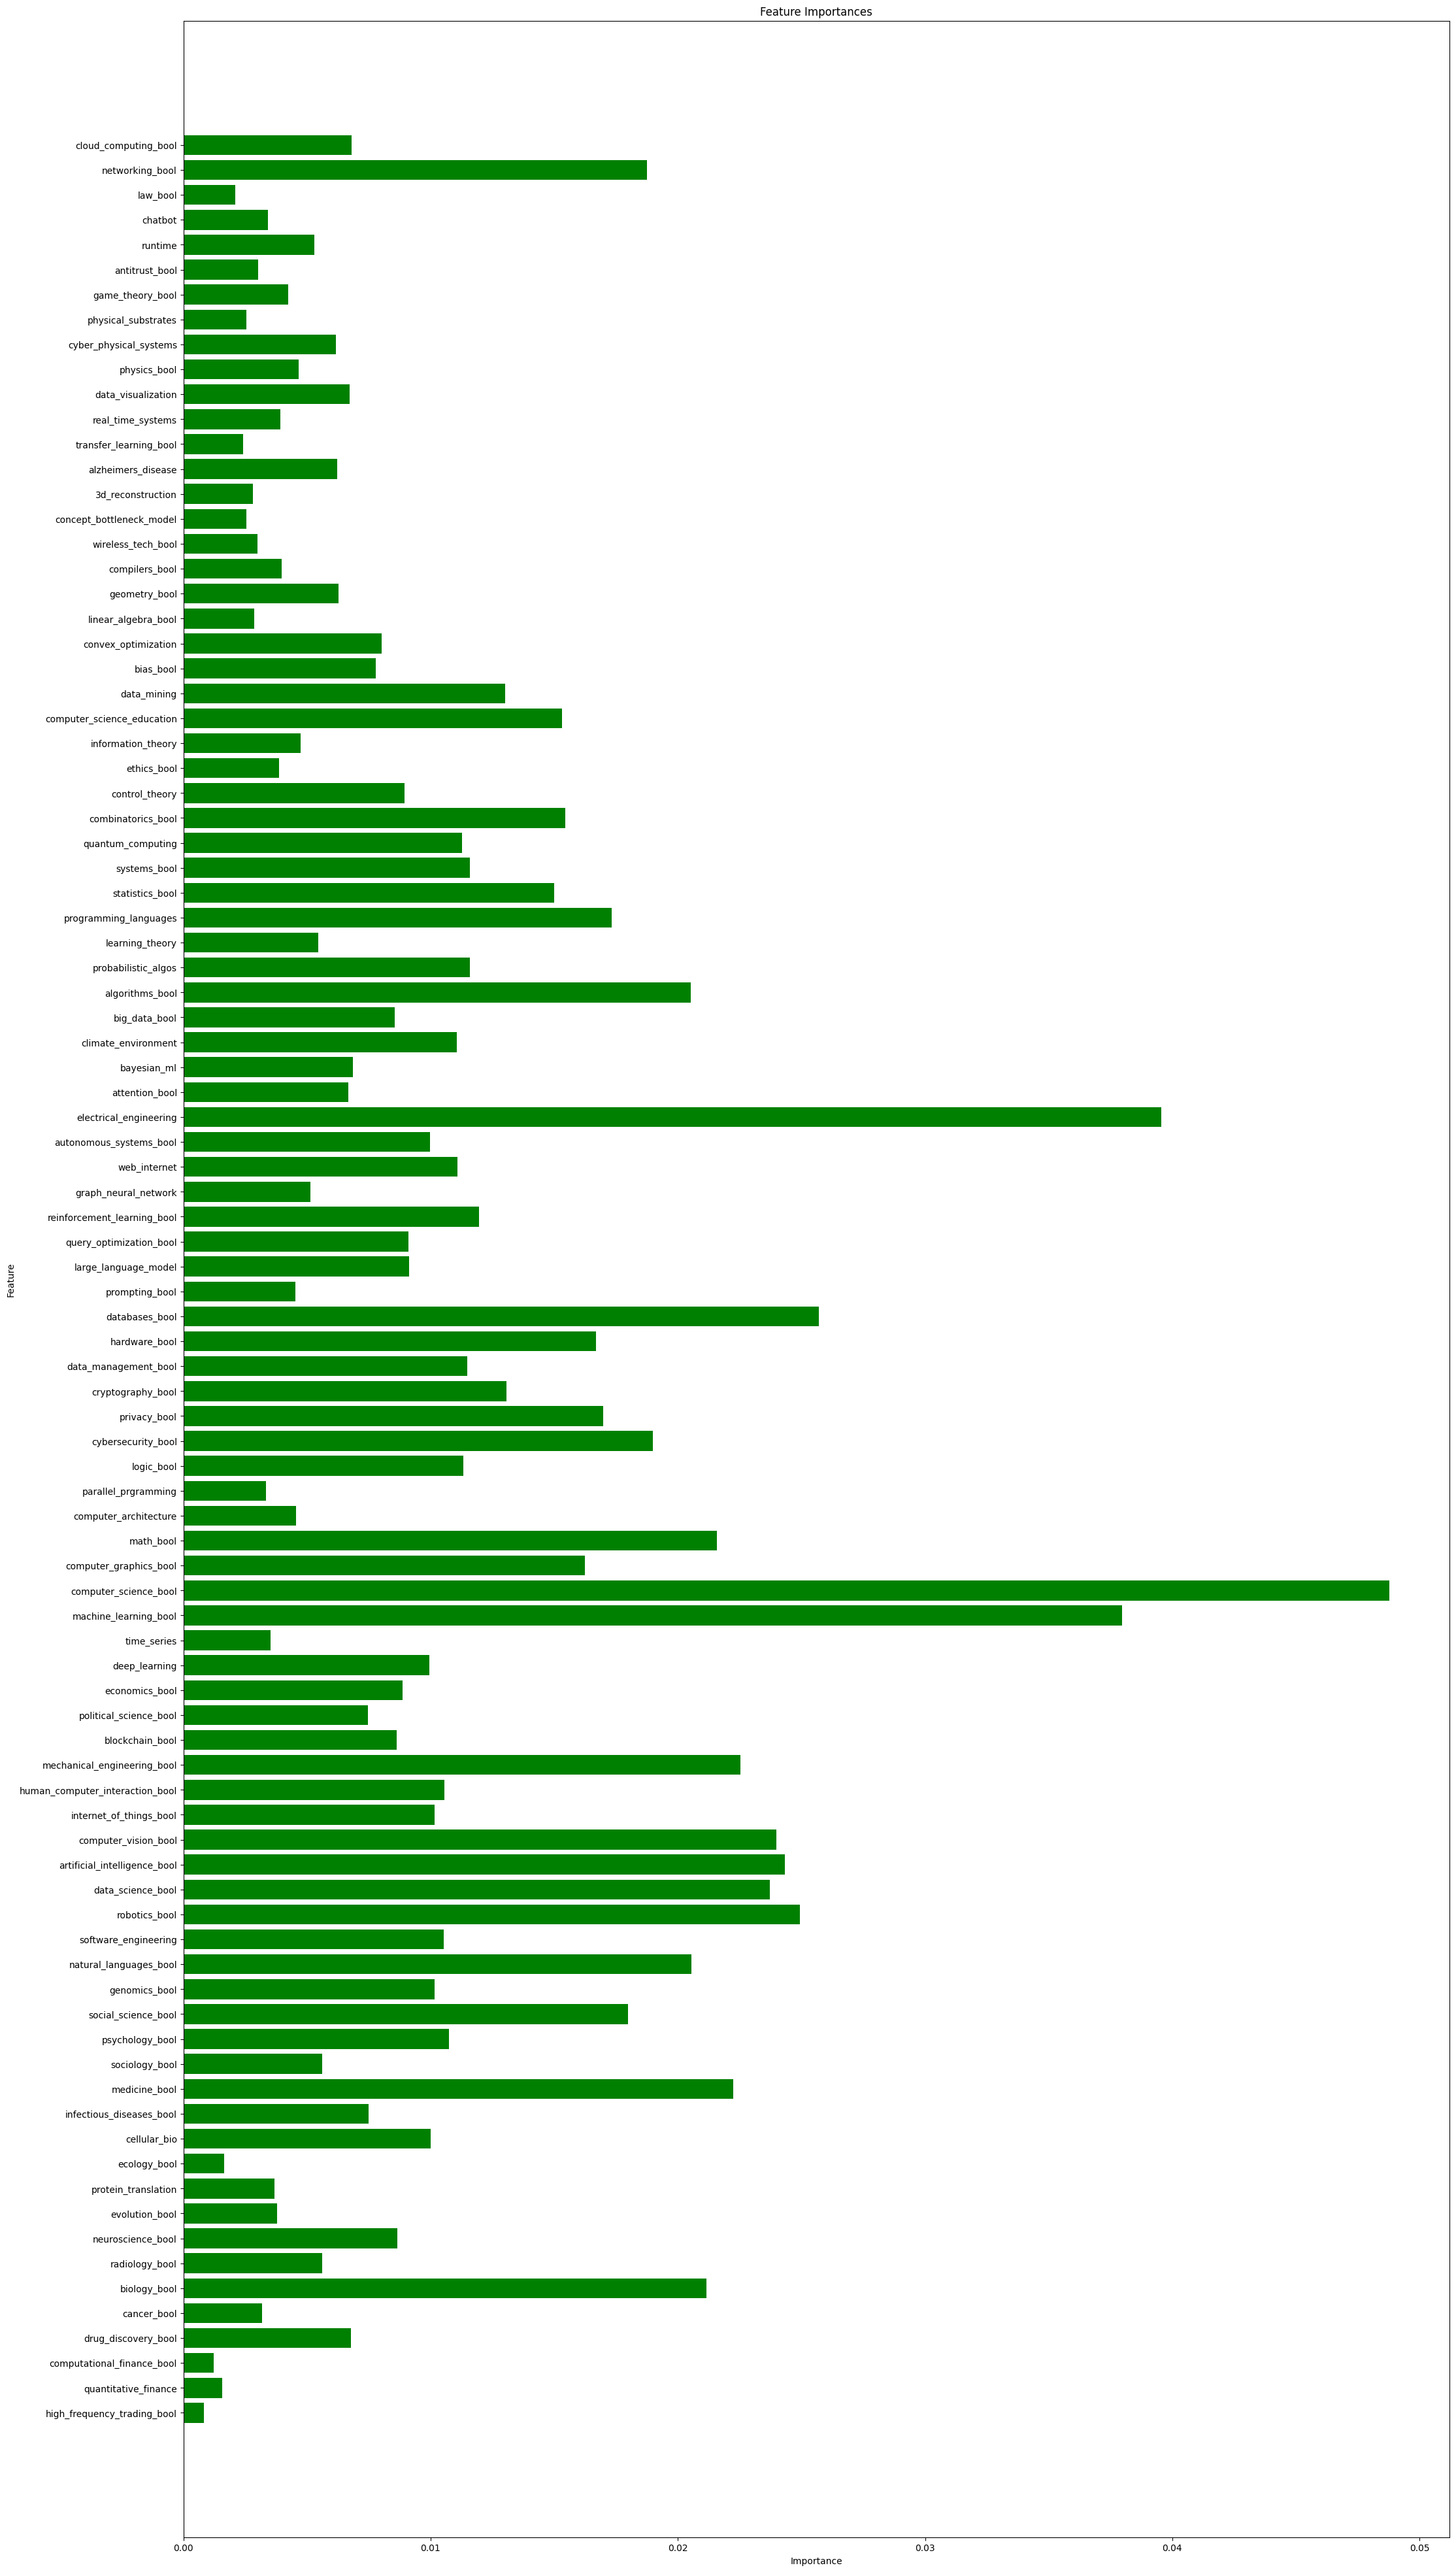

In [ ]:
fig = plt.figure(figsize = (25, 50))

plt.barh(forest_df.feature, forest_df.importance, color ='green')

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.show()

## KNN feature evaluaton approach

- Inspired by https://stackoverflow.com/questions/55314345/how-to-find-feature-importance-or-variable-importance-graph-for-knnclassifier
- KNN code that we built on top of to save time: https://github.com/chingisooinar/KNN-python-implementation/blob/main/k_nearest_neighbors_from_scratch.ipynb

In [ ]:
X_train = df.drop(columns='professor')
y_train = df[['professor']]

In [ ]:
X_test = df_q.drop(columns='question')
y_test = df_excel['Expected Response']

In [ ]:
from math import sqrt
import random

class KNN():

  def __init__(self,k, cols, question):
    self.k=k
    self.features = cols
    self.question = question
    self.cols = list(self.features)
    self.final_df = pd.DataFrame(columns=self.cols)
    self.data_dict = {}
    for features in self.cols:
      self.data_dict[features] = []

  def fit(self,X_train,y_train):
    self.x_train=X_train
    self.y_train=y_train

  def calculate_euclidean(self,sample1,sample2):
    distance=0.0
    d = []
    for i in range(len(sample1)):
      d.append((sample1[i]-sample2[i])**2)
      distance+=(sample1[i]-sample2[i])**2
    return sqrt(distance), d

  def nearest_neighbors(self,test_sample):
    distances=[]
    dist = {}
    for i in range(len(self.x_train)):
      distance, dist_list = self.calculate_euclidean(self.x_train.iloc[i],test_sample)
      distances.append((self.y_train.iloc[i],dist))
      idx = 0
      for feat in self.features:
        if feat not in dist:
          dist[feat] = []
        dist[feat].append(dist_list[idx])
        idx += 1
      dist_df = pd.DataFrame(dist)
      dist_df['final_dist'] = distance
    dist_df = dist_df.sort_values(by='final_dist', ascending=False)
    closest_neighbor = dist_df.drop(columns=['final_dist']).iloc[0]
    for i in range(5):
      rand_int = random.randint(1, 92)
      ratios = closest_neighbor / dist_df.iloc[rand_int].replace(0, .00000001)
      for i in range(len(self.cols)):
        self.data_dict[self.cols[i]].append(ratios[i])
    data_df = pd.DataFrame(self.data_dict)
    return data_df

  def predict(self,test_set):
    predictions=[]
    for i in range(len(test_set)):
      neighbors=self.nearest_neighbors(test_set.iloc[i])
      break
      labels=[sample for sample in neighbors]
      prediction=max(labels,key=labels.count)
      predictions.append(prediction)
    return neighbors

In [ ]:
%%time
model=KNN(1, X_train.columns, df_q[['question']])
model.fit(X_train,y_train)

CPU times: user 5.76 ms, sys: 0 ns, total: 5.76 ms
Wall time: 5.78 ms


In [ ]:
%%time
df_analyze = model.predict(X_test)

In [ ]:
df_analyze = pd.DataFrame(df_analyze.sum(), columns=['sum']).reset_index().rename(columns={'index':'features'})

In [ ]:
df_analyze = df_analyze.sort_values(by='sum', ascending=True)

In [ ]:
df_analyze[df_analyze['sum'].astype(int) > 0][:25]

,features,sum
69,data_mining,5
80,real_time_systems,5
27,blockchain_bool,5
39,cybersecurity_bool,5
73,geometry_bool,5
89,law_bool,5
15,psychology_bool,5
65,control_theory,5
37,parallel_prgramming,5
17,genomics_bool,5
